#follow this to install prismnet
https://github.com/kuixu/PrismNet

In [1]:
import argparse, os, random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler



from sklearn import metrics
import numpy as np

import prismnet.model as arch
from prismnet import train, validate, inference, log_print, compute_saliency, compute_saliency_img, compute_high_attention_region
#compute_high_attention_region

# from prismnet.engine.train_loop import 
from prismnet.model.utils import GradualWarmupScheduler
from prismnet.loader import SeqicSHAPE
from prismnet.utils import datautils

In [2]:
# # out dir

# identity   = args.p_name+'_'+args.arch+"_"+args.mode # 441_PUM2_K562_sub4509_PrismNet_pu.metrics
# datautils.make_directory(args.out_dir,"out/")
# model_dir  = datautils.make_directory(args.out_dir,"out/models")
# model_path = os.path.join(model_dir, identity+"_{}.pth")

# if args.tfboard:
#     tfb_dir  = datautils.make_directory(args.out_dir,"out/tfb")
#     writer = SummaryWriter(tfb_dir)
# else:
#     writer = None
# # fix random seed
# fix_seed(args.seed)

In [3]:
import pandas as pd
outstem = 'K562_rep6'
megaoutput = pd.read_csv(f'../data/ABC_data/{outstem}.megaoutputs_masked.tsv', sep = '\t')
seq = pd.read_csv(f'../data/ABC_data/tsv/{outstem}.DDX3.tsv', sep = '\t', names = ['chrom', 'name', 
                                                                     'seq', 'struct', 'label', 'start'])
signal = 'COV'

In [4]:
max_length=seq['seq'].str.len().max()

In [5]:
from prismnet.utils import datautils

In [6]:
one_hot = datautils.convert_one_hot(seq['seq'], max_length)

In [7]:
one_hot.shape # N, 4, max_length

(138498, 4, 100)

In [8]:
data = one_hot

In [9]:
# targets: predict binary
target_col = megaoutput.columns[(megaoutput.columns.str.startswith('logLR'))&(megaoutput.columns.str.contains(outstem))]
target_df = megaoutput[target_col]

<AxesSubplot:>

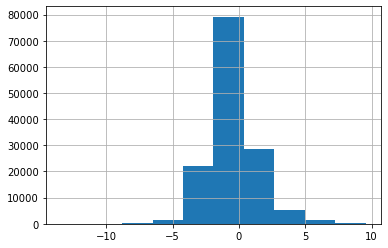

In [10]:
target_df[f'logLR:{outstem}.IGF2BP2'].hist()

<AxesSubplot:>

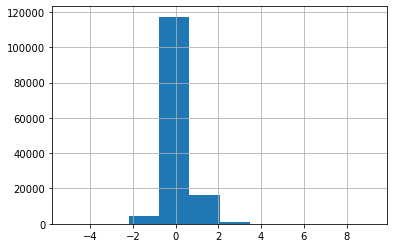

In [11]:
target_df[f'logLR:{outstem}.PUM2'].hist()

In [12]:
targets = target_df.values
targets.shape

(138498, 10)

In [13]:
cits_target = np.load(f'../data/{signal}/{outstem}.cits_cnt.npz.npy')

In [14]:
def split_dataset(data, targets, cits_target, valid_frac=0.2):
    
    ind0 = np.where(targets<0.5)[0]
    ind1 = np.where(targets>=0.5)[0]
    
    n_neg = int(len(ind0)*valid_frac)
    n_pos = int(len(ind1)*valid_frac)

    shuf_neg = np.random.permutation(len(ind0))
    shuf_pos = np.random.permutation(len(ind1))
    
    train_index = np.concatenate([ind1[shuf_pos[n_pos:]],ind0[shuf_neg[n_neg:]]])
    test_index = np.concatenate([ind1[shuf_pos[:n_pos]],ind0[shuf_neg[:n_neg]]])
    
    return train_index, test_index

In [15]:
train_index, test_index = split_dataset(data, targets, cits_target, valid_frac=0.2)

train_index = train_index
test_index = test_index

In [16]:
target_data_type = np.float32

In [17]:
from prismnet.model.PrismNet import *
class PrismNet_Multitask_BP(nn.Module):
    def __init__(self, mode="pu", output_dim=10):
        super(PrismNet_Multitask_BP, self).__init__()
        self.mode = mode
        h_p, h_k = 2, 5 
        if mode=="pu":
            self.n_features = 5
        elif mode=="seq":
            self.n_features = 4
            h_p, h_k = 1, 3 
        elif mode=="str":
            self.n_features = 1
            h_p, h_k = 0, 1
        else:
            raise "mode error"
        
        base_channel = 8
        self.conv    = Conv2d(1, base_channel, kernel_size=(11, h_k), bn = True, same_padding=True)
        self.se      = SEBlock(base_channel)
        self.res2d   = ResidualBlock2D(base_channel, kernel_size=(11, h_k), padding=(5, h_p)) 
        self.res1d   = ResidualBlock1D(base_channel*4) 
        self.avgpool = nn.AvgPool2d((1,self.n_features))
        self.gpool   = nn.AdaptiveAvgPool1d(1)
        self.fc      = nn.Linear(base_channel*4*8, output_dim)
        self._initialize_weights()
        
        self.bp_fc = nn.Linear(base_channel*self.n_features, output_dim)
        self.bp_softmax = nn.Softmax(dim = -1)
        

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, input):
        """[forward]
        
        Args:
            input ([tensor],N,C,W,H): input features
        """
        if self.mode=="seq":
            input = input[:,:,:,:4]
        elif self.mode=="str":
            input = input[:,:,:,4:]
        x = self.conv(input) # batch_size, 8, max_length, 4(seq_channel)
        
        x = F.dropout(x, 0.1, training=self.training)
        
        bp_input = torch.permute(x, (0,2,1,3)).flatten(start_dim=2, end_dim = -1)
        bp_output = self.bp_fc(bp_input)
        bp_prob = self.bp_softmax(bp_output)
        
        z = self.se(x)
        x = self.res2d(x*z)
        x = F.dropout(x, 0.5, training=self.training)
        x = self.avgpool(x)
        x = x.view(x.shape[0], x.shape[1], x.shape[2])
        x = self.res1d(x)
        x = F.dropout(x, 0.3, training=self.training)
        x = self.gpool(x)
        x = x.view(x.shape[0], x.shape[1])
        x = self.fc(x)
        
        
        return x, bp_prob

In [18]:
model = PrismNet_Multitask_BP(mode = 'seq', output_dim = targets.shape[1])

In [19]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [20]:
model = model.to(device)

In [21]:
class SeqicSHAPE_Multitask_BP(torch.utils.data.Dataset):
    def __init__(self, X, Y, Y_cits,indices, is_infer=False, use_structure=True):
        """data loader
        
        Args:
            data_path ([str]): h5 file path
            is_test (bool, optional): testset or not. Defaults to False.
        """
        if is_infer:
            self.dataset = self.__load_infer_data__(data_path, use_structure=use_structure)
            print("infer data: ", self.__len__()," use_structure: ", use_structure)
        else:
#             dataset = h5py.File(data_path, 'r')
#             X_train = np.array(dataset['X_train']).astype(np.float32)
#             Y_train = np.array(dataset['Y_train']).astype(np.int32)
#             X_test  = np.array(dataset['X_test']).astype(np.float32)
#             Y_test  = np.array(dataset['Y_test']).astype(np.int32)
            X = np.array(X).astype(np.int8)
            Y = np.array(Y).astype(np.float32)
            Y_cits = np.array(Y_cits).astype(np.int8)
#             if len(Y_train.shape) == 1:
#                 Y_train = np.expand_dims(Y_train, axis=1)
#                 Y_test  = np.expand_dims(Y_test, axis=1)
            print('expand')
            X = np.expand_dims(X, axis=3).transpose([0, 3, 2, 1]) # N, 1, length, channel
            

            

#             labels, nums = np.unique(Y_train,return_counts=True)
#             print("train:", labels, nums)
#             labels, nums = np.unique(Y_test,return_counts=True)
#             print("test:", labels, nums)

#             train = self.__prepare_data__(train)
#             test  = self.__prepare_data__(test)

            
            self.dataset = {'inputs': X, 'targets': Y, 'targets_cits': Y_cits}
            self.indices = indices
            

        

    def __load_infer_data__(self, data_path, use_structure=True):
        from prismnet.utils import datautils
        dataset = datautils.load_testset_txt(data_path, use_structure=use_structure, seq_length=101)
        return dataset
       
    
    def __prepare_data__(self, data):
        inputs    = data['inputs'][:,:,:,:4]
        structure = data['inputs'][:,:,:,4:]
        structure = np.expand_dims(structure[:,:,:,0], axis=3)
        inputs    = np.concatenate([inputs, structure], axis=3)
        data['inputs']  = inputs
        return data

    def __to_sequence__(self, x):
        x1 = np.zeros_like(x[0,:,:1])
        for i in range(x1.shape[0]):
            # import pdb; pdb.set_trace()
            x1[i] = np.argmax(x[0,i,:4])
            # import pdb; pdb.set_trace()
        return x1

    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        x = self.dataset['inputs'][self.indices[index]]
        # x = self.__to_sequence__(x)
        y = self.dataset['targets'][self.indices[index]]
        y_cits = self.dataset['targets_cits'][self.indices[index]]
        return x, y, y_cits


    def __len__(self):
        return len(self.indices)



In [23]:
kwargs = {'num_workers': 2, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    
    
    SeqicSHAPE_Multitask_BP(data, targets, cits_target, train_index,
                            is_infer=False, use_structure=False), 
batch_size=32, shuffle=True,  **kwargs)

test_loader  = torch.utils.data.DataLoader(
    SeqicSHAPE_Multitask_BP(data, targets, cits_target, test_index, 
                         is_infer=False, use_structure=False),
batch_size=32*8, shuffle=False, **kwargs)

print("Train set:", len(train_loader.dataset)) #X_train (example=91099, ATCGshape=5, length=101)
#X_train (example=91099, ATCGshape=5, length=101)
#Y_train (example=91099, binary_outcome=1))
print("Test  set:", len(test_loader.dataset))

expand
expand
Train set: 1107985
Test  set: 276995


In [24]:
def train(model, device, train_loader, criterion, optimizer, multinomial_loss_weight = 100):
    ''' train for one epoch'''
    model.train()
    epoch_loss = 0
    epoch_loss_lr = 0
    epoch_loss_multinomial = 0
    for batch_idx, (x0, y0, y0_cits) in enumerate(train_loader):
        x, y, y_cits = x0.float().to(device), y0.to(device).float(), y0_cits.to(device).float()
        
        optimizer.zero_grad()
        output, bp_output = model(x)
        multinomial_nll=-torch.distributions.Multinomial(probs=bp_output, validate_args = False).log_prob(y_cits).sum()
        lr_mle_loss =criterion(output, y)
        
        loss = lr_mle_loss+multinomial_nll*multinomial_loss_weight
            
        epoch_loss+=loss.item()
        epoch_loss_lr+=lr_mle_loss.item()
        epoch_loss_multinomial+=multinomial_nll.item()
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
        optimizer.step()

    return epoch_loss, epoch_loss_lr, epoch_loss_multinomial
def validate(model, device, test_loader, criterion, multinomial_loss_weight = 100):
    model.eval()
    y_all = []
    p_cits_all = []
    p_all = []
    l_all = []
    epoch_loss = 0
    epoch_loss_lr = 0
    epoch_loss_multinomial = 0
    with torch.no_grad():
        for batch_idx, (x0, y0, y0_cits) in enumerate(test_loader):
            x, y, y_cits = x0.float().to(device), y0.to(device).float(), y0_cits.to(device).float()
            
            
            output, bp_output  = model(x)
            multinomial_nll=-torch.distributions.Multinomial(probs=bp_output, validate_args = False).log_prob(y_cits).sum()
            
            multinomial_nll=-torch.distributions.Multinomial(probs=bp_output, validate_args = False).log_prob(y_cits).sum()
            lr_mle_loss =criterion(output, y)
        
            loss = lr_mle_loss+multinomial_nll*multinomial_loss_weight
            
            epoch_loss+=loss.item()
            epoch_loss_lr+=lr_mle_loss.item()
            epoch_loss_multinomial+=multinomial_nll.item()
            y_np = output.to(device='cpu', dtype=torch.float32).numpy()
            y_all.append(y_np)
            p_cits = bp_output.to(device='cpu', dtype=torch.float32).numpy()
            p_cits_all.append(p_cits)
            

    return epoch_loss, epoch_loss_lr, epoch_loss_multinomial, y_all, p_cits_all

In [25]:
try:
    metric=pd.read_csv(f'../data/ABC_data/{outstem}.BP.training_curve.csv')
except:
    pass

In [26]:
model.load_state_dict(torch.load(f'../data/ABC_data/{outstem}.BP.model.pt'))

<All keys matched successfully>

In [ ]:
#metric.to_csv(f'../data/ABC_data/{outstem}.training_curve.csv')

In [27]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.999), weight_decay=1e-6)
nepoch = 60
scheduler = GradualWarmupScheduler(
    optimizer, multiplier=8, total_epoch=nepoch, after_scheduler=None)
criterion = torch.nn.MSELoss()
batch_size= 32

In [28]:
epoch_loss, epoch_loss_lr, epoch_loss_multinomial, y_all, p_cits_all = validate(model, device, test_loader, criterion)

# Training curve

In [29]:

metric=pd.read_csv(f'../data/ABC_data/{outstem}.BP.training_curve.csv')


type
test     [AxesSubplot(0.125,0.71587;0.775x0.16413), Axe...
train    [AxesSubplot(0.125,0.71587;0.775x0.16413), Axe...
dtype: object

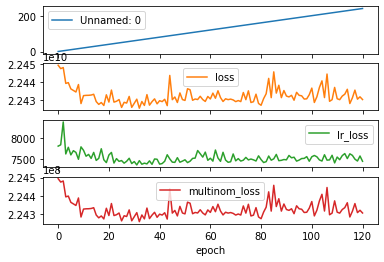

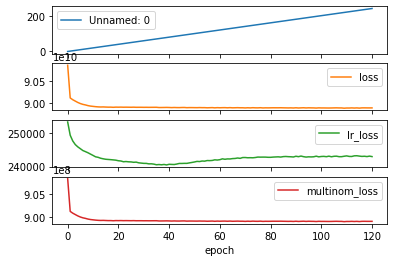

In [30]:
metric.set_index('epoch').groupby(by = 'type').plot(subplots = True)

In [31]:
test = targets[test_index]
cits_target_test = cits_target[test_index]

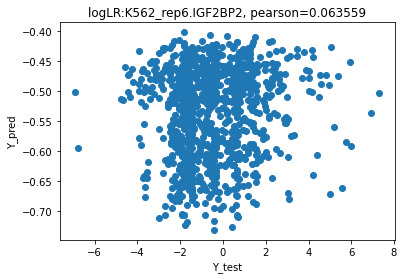

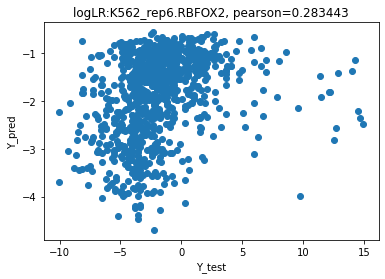

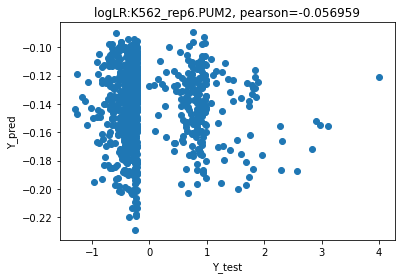

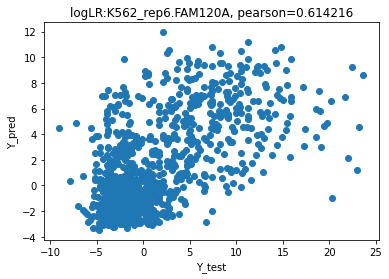

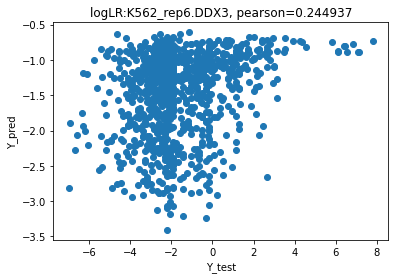

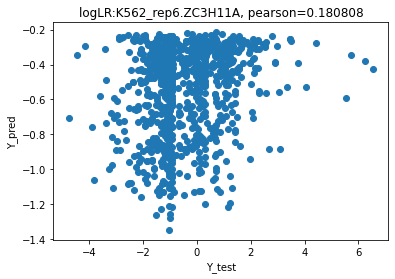

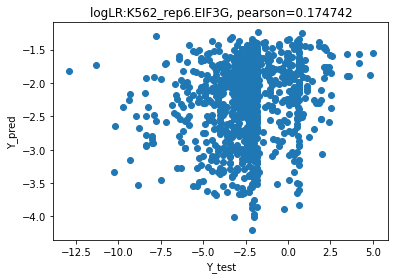

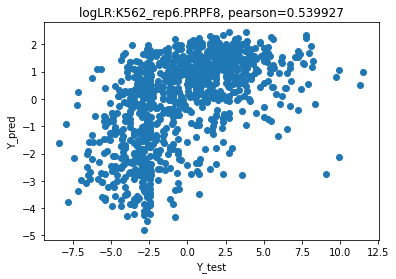

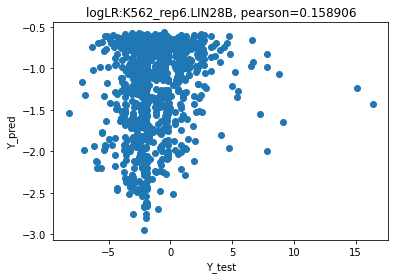

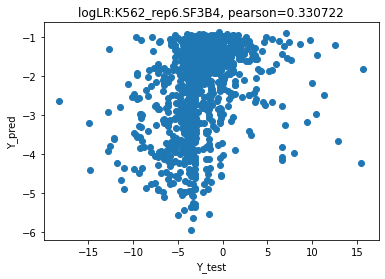

In [33]:
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
pearsondf = []
y_pred=np.concatenate(y_all)
for rbp_idx, name in zip(range(y_pred.shape[1]), target_df.columns):
    plt.scatter(test[:1000, rbp_idx], y_pred[:1000, rbp_idx])
    plt.xlabel('Y_test')
    plt.ylabel('Y_pred')
    r,p=pearsonr(test[:1000, rbp_idx],y_pred[:1000, rbp_idx])
    plt.title(f'{name}, pearson={r:2f}')
    plt.show()
    pearsondf.append([name, r, p])
pearsondf = pd.DataFrame(pearsondf, columns = ['RBP', 'pearsonr', 'pvalue'])
pearsondf.to_csv(f'../data/ABC_data/{outstem}.pearsonr.BP.csv')

In [ ]:
#pearsondf_region = pd.read_csv(f'../data/ABC_data/{outstem}.region_type.pearsonr.csv')
pearsondf_raw = pd.read_csv(f'../data/ABC_data/{outstem}.pearsonr.csv')
pearsondf_raw.merge(pearsondf, left_on = ['RBP'], right_on = ['RBP'], suffixes = ('', '_BP')
                      ).plot.scatter(x = 'pearsonr', y = 'pearsonr_BP')

plt.plot([0,1], [0,1])
sns.despine()

# Visualize COV/CITS prediction

In [38]:
p_cits_pred=np.concatenate(p_cits_all)
p_cits_pred.shape # predicted probability

(276995, 100, 10)

In [35]:
cits_target_test.shape #N, max_length=100, 10 RBPs

(276995, 100, 10)

In [36]:
# probability of crosslinking across 10 RBP as trained 
p_cits_target_test = cits_target_test/np.stack([cits_target_test.sum(axis = -1)]*cits_target_test.shape[-1], axis = -1)

/tmp/ipykernel_843/693615578.py:2: RuntimeWarning: invalid value encountered in true_divide
  p_cits_target_test = cits_target_test/np.stack([cits_target_test.sum(axis = -1)]*cits_target_test.shape[-1], axis = -1)


In [37]:
p_cits_target_test.shape

(276995, 100, 10)

array([False, False, False, ...,  True,  True,  True])

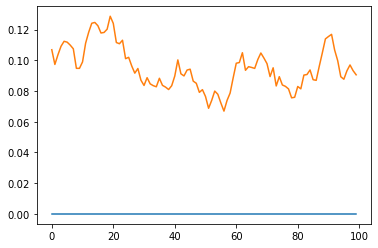

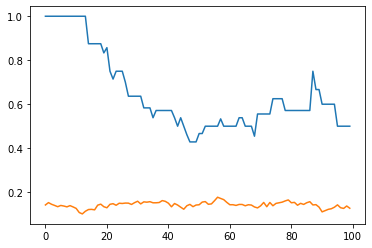

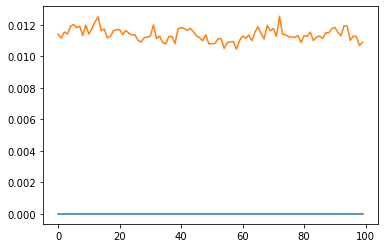

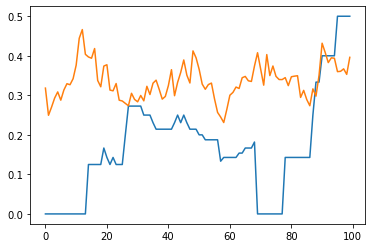

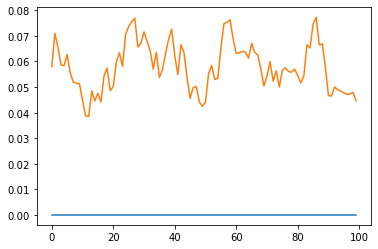

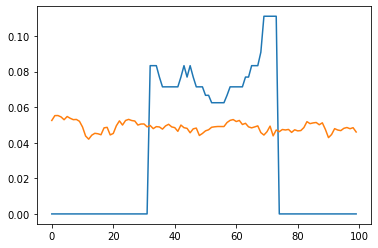

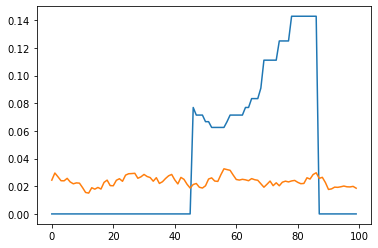

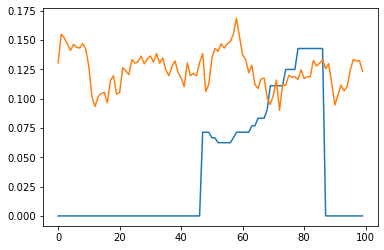

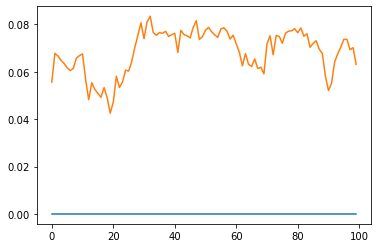

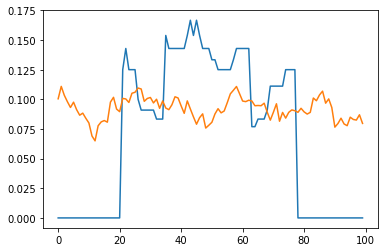

In [58]:
# correlation between probability
pearsondf_bp = []
for rbp_idx, name in zip(range(y_pred.shape[1]), target_df.columns):
    y_test_p = p_cits_target_test[:,:,rbp_idx].flatten()
    has_data = ~np.isnan(y_test_p)
    y_test_p = y_test_p[has_data]
    y_pred_p = p_cits_pred[:,:,rbp_idx].flatten()[has_data]
    r,p=pearsonr(y_test_p,y_pred_p)
    pearsondf_bp.append([name, r, p])
    #plt.scatter(y_test_p, y_pred_p)
    plt.plot(y_test_p[:100])
    plt.plot(y_pred_p[:100])
    plt.show()
pearsondf_bp = pd.DataFrame(pearsondf_bp, columns = ['RBP', 'pearson', 'pvalue'])

In [51]:
pearsondf_bp.sort_values(by = 'pearson')

,RBP,pearson,pvalue
2,logLR:K562_rep6.PUM2,0.004699,4.001942e-117
5,logLR:K562_rep6.ZC3H11A,0.068688,0.000000e+00
0,logLR:K562_rep6.IGF2BP2,0.096014,0.000000e+00
6,logLR:K562_rep6.EIF3G,0.103047,0.000000e+00
8,logLR:K562_rep6.LIN28B,0.114050,0.000000e+00
9,logLR:K562_rep6.SF3B4,0.114522,0.000000e+00
1,logLR:K562_rep6.RBFOX2,0.146979,0.000000e+00
4,logLR:K562_rep6.DDX3,0.166713,0.000000e+00
7,logLR:K562_rep6.PRPF8,0.188380,0.000000e+00
3,logLR:K562_rep6.FAM120A,0.336364,0.000000e+00


In [59]:
n_csln_per_region = cits_target_test.sum(axis = -1).sum(axis = -1)
n_cits_per_rbp = cits_target_test.sum(axis = 0).sum(axis = 0)
p_cits_per_rbp = n_cits_per_rbp/n_cits_per_rbp.sum()

In [60]:
high_cov_regions = np.where(n_csln_per_region>100)[0]
region_idx = np.where(n_csln_per_region>500)[0][1]

In [61]:
fc_target = p_cits_target_test/p_cits_per_rbp
fc_pred = p_cits_pred/p_cits_per_rbp

In [62]:
n_csln_per_rbp_per_region = cits_target_test.sum(axis = 1)


In [ ]:


rbp_idx =0
high_cov_regions = np.where(n_csln_per_rbp_per_region[:, rbp_idx]>50)[0]
data = pd.DataFrame([fc_target[high_cov_regions,:,rbp_idx].flatten(),
                     fc_pred[high_cov_regions,:,rbp_idx].flatten()],
                    index = ['fc_test', 'fc_pred']
                     ).T.dropna()
data.plot.scatter(x = 'fc_test', y='fc_pred',
           alpha = 0.3)

sns.kdeplot(data = data.sample(500), x = 'fc_test', y = 'fc_pred')
pearsonr(data['fc_test'], data['fc_pred'])

In [ ]:
n_cits_per_nucleotide_per_region = cits_target_test.sum(axis = -1)

In [ ]:
plt.hist(n_cits_per_nucleotide_per_region.flatten())

In [ ]:
region_idx, nu_idx = np.where(n_cits_per_nucleotide_per_region>100)

In [ ]:
len(region_idx)

In [ ]:
rbp_idx = 0
data = pd.DataFrame([fc_target[region_idx,nu_idx,rbp_idx].flatten(),
                     fc_pred[region_idx,nu_idx,rbp_idx].flatten()],
                    index = ['fc_test', 'fc_pred']
                     ).T.dropna()
data.plot.scatter(x = 'fc_test', y='fc_pred',
           alpha = 0.3)

sns.kdeplot(data = data.sample(500), x = 'fc_test', y = 'fc_pred')
pearsonr(data['fc_test'], data['fc_pred'])

In [ ]:



region_idx = np.where(n_csln_per_region>1000)[0][2]
rbp_names = [c.split('.')[1] for c in target_df.columns]
f, ax = plt.subplots(2,1, figsize = (12,6), sharex = True)
fc_raw = (p_cits_target_test[region_idx,:,:]/p_cits_per_rbp)
fc_pred = (p_cits_pred[region_idx,:,:]/p_cits_per_rbp)
sns.heatmap(fc_raw.T, cmap = 'Greys', yticklabels = rbp_names, ax = ax[0])
sns.heatmap(fc_pred.T, cmap = 'Greys', yticklabels = rbp_names, ax = ax[1])



In [ ]:
rbp_idx = 2
plt.scatter(np.arange(fc_raw.shape[0]), fc_raw[:, rbp_idx], label = 'fc_raw', marker = '.')
plt.plot(fc_pred[:, rbp_idx], label = 'fc_pred', color = 'black')
plt.legend()
plt.ylabel('Fold change crosslinking frequency')
plt.xlabel('Nucleotide positions')
sns.despine()
plt.show()

plt.scatter(fc_raw[:, rbp_idx], fc_pred[:, rbp_idx])
plt.ylabel('Predicted CITS fold change')
plt.xlabel('CITS fold change')


In [ ]:
plt.scatter(p_cits_target_test[:1000, :, rbp_idx].flatten(),
    p_cits_pred[:1000, :, rbp_idx].flatten()
           )

In [ ]:
import seaborn as sns
